### Import libraries

In [1]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import tensorflow as tf
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

import random
random.seed(seed)

tfk = tf.keras
tfkl = tf.keras.layers

from tensorflow.keras import backend as K
import tf2onnx
import onnxruntime as rt
rt.set_default_logger_severity(3)

import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.utils.class_weight import compute_class_weight
import cv2
import re


from scipy import special
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData, AttackType, SlicingSpec

from utils import *

### Load and prepare data

In [2]:
dataset = 'breast'

if(dataset == 'fashion_mnist'): # Image classification
    (X_train, y_train), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()
    X = np.concatenate([X_train, X_test],axis=0)
    padding = ((0, 0), (2, 2), (2, 2))
    X = np.expand_dims(np.pad(X, padding, mode='constant'),axis=-1)
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'FASHION MNIST'
    batch_size = 256
    
elif(dataset == 'cifar10'): # Image classification
    (X_train, y_train), (X_test, y_test) = tfk.datasets.cifar10.load_data()
    X = np.concatenate([X_train, X_test],axis=0)
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'CIFAR10'
    batch_size = 256
    
elif(dataset == 'cifar100'): # Image classification
    (X_train, y_train), (X_test, y_test) = tfk.datasets.cifar100.load_data()
    X = np.concatenate([X_train, X_test],axis=0)
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'CIFAR100'
    batch_size = 256
    
elif(dataset == 'mnist'): # Image classification
    (X_train, y_train), (X_test, y_test) = tfk.datasets.mnist.load_data()
    X = np.concatenate([X_train, X_test],axis=0)
    padding = ((0, 0), (2, 2), (2, 2))
    X = np.expand_dims(np.pad(X, padding, mode='constant'),axis=-1)
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'MNIST'
    batch_size = 256
    
elif(dataset == 'breast'): # Tabular classification
    data = load_breast_cancer()
    X = data['data']
    y = tfk.utils.to_categorical(np.expand_dims(data['target'],axis=-1))
    task = 'classification'
    data_structure = 'tabular'
    dataset_name = 'Breast Cancer'
    batch_size = 64

In [3]:
temp_X = X
temp_y = y

if data_structure == 'image':
    temp_X = ((temp_X - temp_X.min(axis=(0,1,2))) / (temp_X.max(axis=(0,1,2)) - temp_X.min(axis=(0,1,2)))).astype('float32')
elif data_structure == 'tabular':
    temp_X = ((temp_X - temp_X.min(axis=0)) / (temp_X.max(axis=0) - temp_X.min(axis=0))).astype('float32')

if task == 'regression':
    temp_y = ((temp_y - temp_y.min()) / (temp_y.max() - temp_y.min()) * 2 -1).astype('float32')
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
        tfk.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.1, patience=10, min_lr=1e-4, mode='min')
    ]
    X_train, X_test, y_train, y_test = train_test_split(temp_X, temp_y, random_state=seed, test_size=.1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=.1)
elif task == 'classification':
    callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, min_lr=1e-4, mode='max')
    ]
    X_train, X_test, y_train, y_test = train_test_split(temp_X, temp_y, random_state=seed, test_size=.1, stratify=np.argmax(temp_y,axis=1))
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=.1, stratify=np.argmax(y_train,axis=1))

In [4]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

epochs = 500

print(f'Input shape: {input_shape}')
print(f'Output shape: {output_shape}')

Input shape: (30,)
Output shape: (2,)


### Fit with DAP

Shadow models training started...
Model 1/10
Model 2/10
Model 3/10
Model 4/10
Model 5/10
Model 6/10
Model 7/10
Model 8/10
Model 9/10
Model 10/10
Shadow models training completed!
Membership Inference Attack
Features space (510, 4) 	Labels space (510, 1)
DAP discriminator training started...
DAP discriminator training completed!
DAP protected model training started...
Epoch 1/500
8/8 [==============================] - 2s 59ms/step - loss: 1.3822 - cce: 0.6676 - disc_bce: 0.7146 - accuracy: 0.5565 - auc_mia: 0.6105 - aop: 0.3733 - beta: 1.0000 - val_loss: 1.3502 - val_cce: 0.6359 - val_disc_bce: 0.7142 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 0.6896 - cce: 0.5623 - disc_bce: 0.7147 - accuracy: 0.8913 - auc_mia: 0.0613 - aop: 0.8913 - beta: 0.1781 - val_loss: 0.6434 - val_cce: 0.5162 - val_disc_bce: 0.7145 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 3/500
8/8 [==============================] - 0s 14ms/step - loss: 0.4930 - c

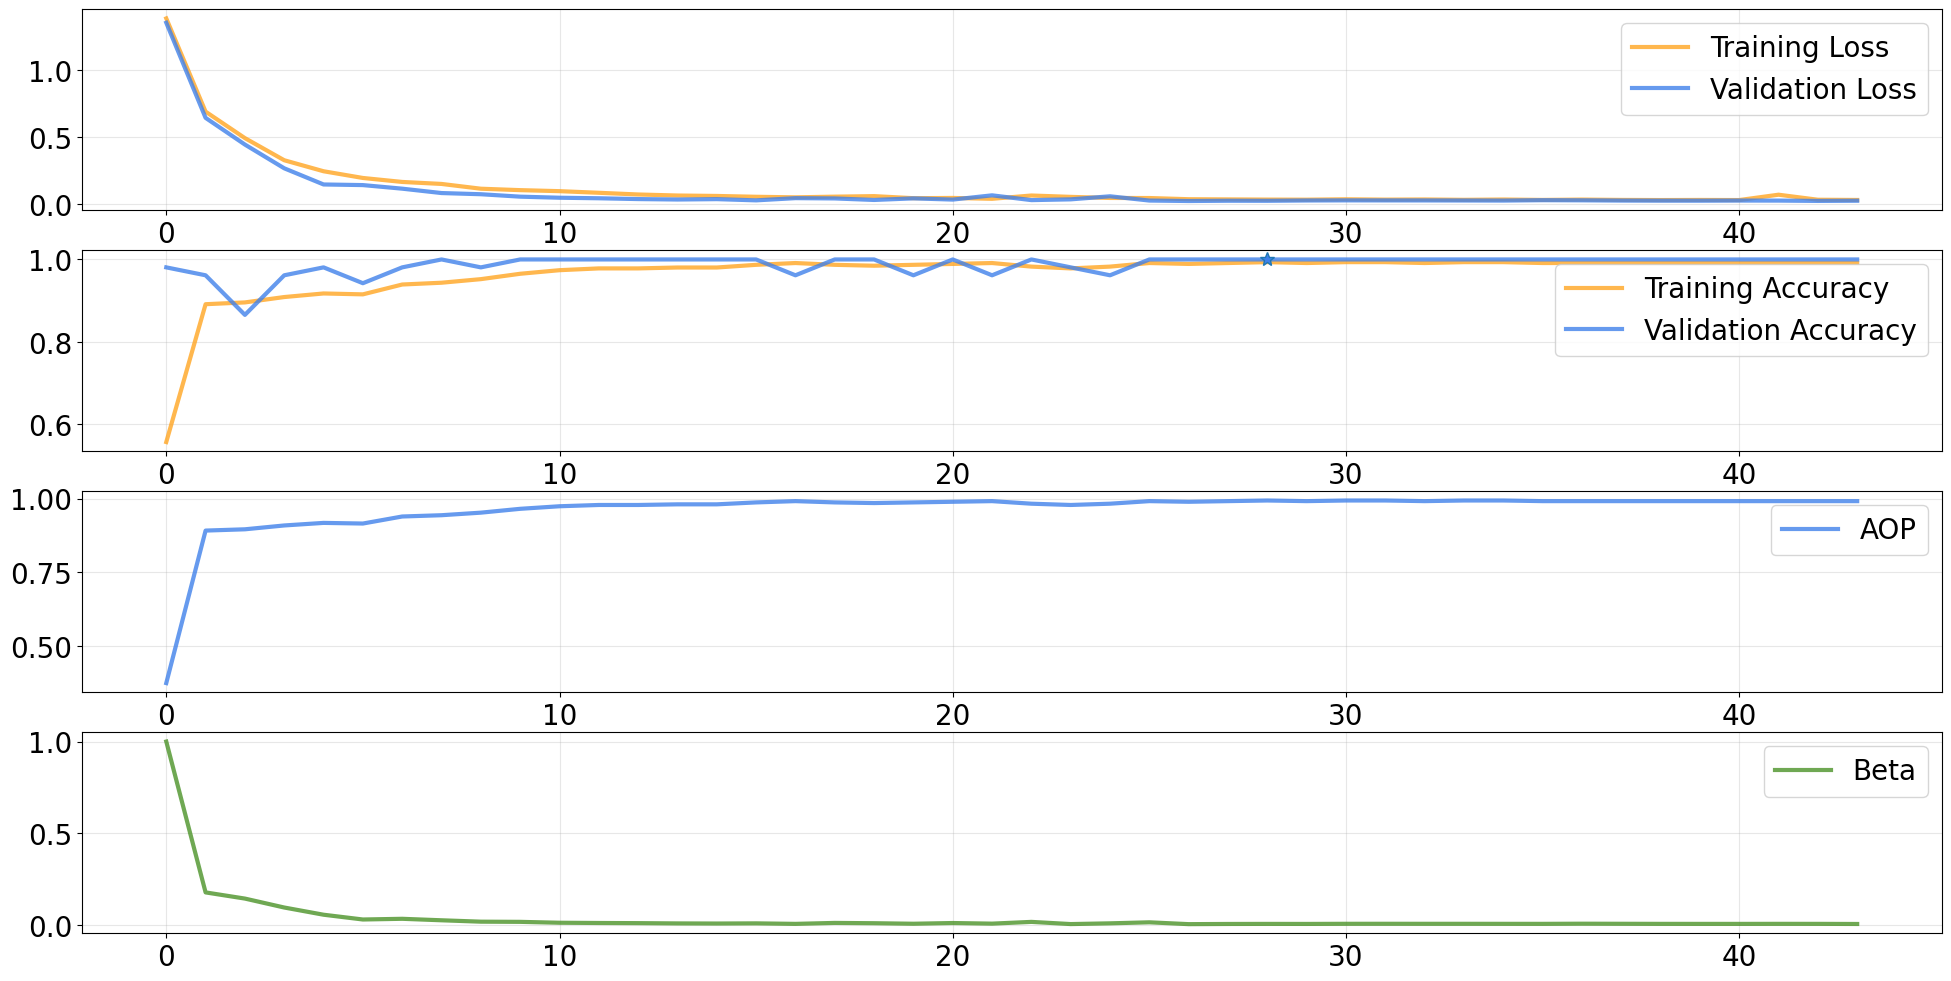

Membership Inference Attack test started...
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=460, ntest=57)
  AttackType: THRESHOLD_ATTACK
  AUC: 0.58
  Attacker advantage: 0.18
  Positive Predictive Value: 0.98
)
Figure(640x480)
Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 460 training and 57 test examples) achieved an AUC of 0.58 on slice Entire dataset
  LOGISTIC_REGRESSION (with 460 training and 57 test examples) achieved an advantage of 0.30 on slice Entire dataset
  THRESHOLD_ATTACK (with 460 training and 57 test examples) achieved a positive predictive value of 0.98 on slice Entire dataset
Membership Inference Attack test completed!


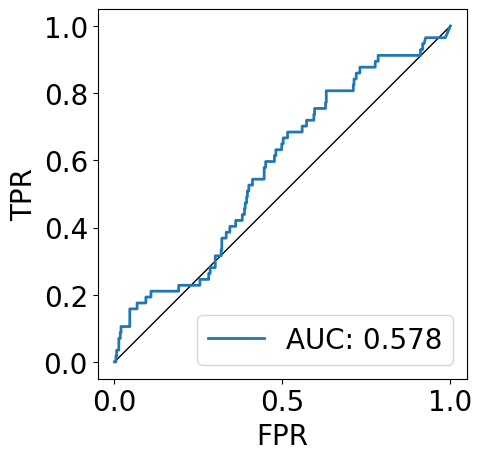

In [5]:
result = dap_fit(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    task=task,
    epochs=epochs,
    batch_size=batch_size,
)

### Test models privacy

Model: "FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 30)]              0         
                                                                 
 fc1 (Dense)                 (None, 64)                1984      
                                                                 
 fc2 (Dense)                 (None, 128)               8320      
                                                                 
 fc3 (Dense)                 (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 2)                 514       
                                                                 
Total params: 43,842
Trainable params: 43,842
Non-trainable pa

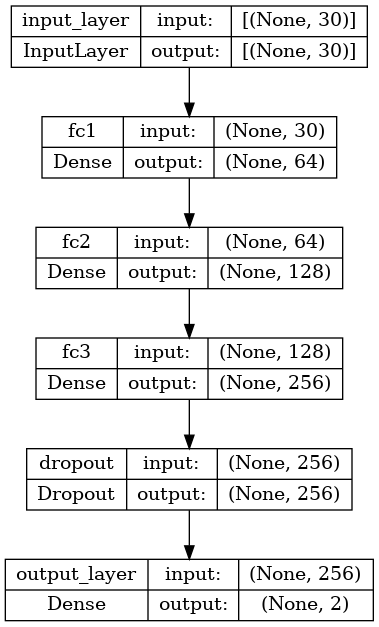

In [10]:
result['protected_model'].summary()
tfk.utils.plot_model(result['protected_model'], show_shapes=True, expand_nested=True)

SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=460, ntest=57)
  AttackType: THRESHOLD_ATTACK
  AUC: 0.58
  Attacker advantage: 0.18
  Positive Predictive Value: 0.98
)
Figure(640x480)
Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 460 training and 57 test examples) achieved an AUC of 0.58 on slice Entire dataset
  LOGISTIC_REGRESSION (with 460 training and 57 test examples) achieved an advantage of 0.31 on slice Entire dataset
  LOGISTIC_REGRESSION (with 460 training and 57 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
AUC from Membership Inference Attack equal to 0.58


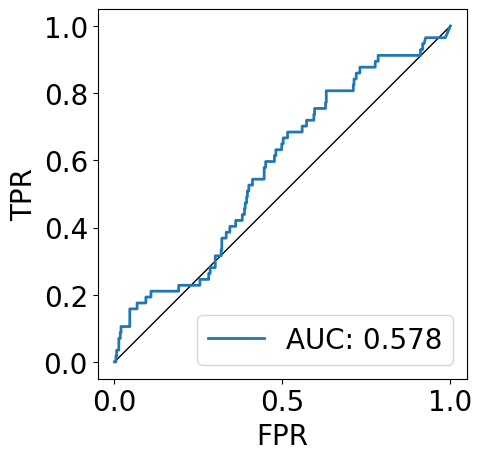

In [11]:
auc_mia = test_model_privacy(result['protected_model'], X_train, y_train, X_test, y_test)
print(f"AUC from Membership Inference Attack equal to {auc_mia}")